# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [22]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

Using given hyperparameters


Row,Ω,stats
,Any,Any
1,"[0.158378, 0.803295]","[0.0, 12.5815]"
2,"[0.158378, 0.803295]","[0.979359, 16.0875]"
3,"[0.176989, 0.828399]","[6.20798, 18.1264]"
4,"[0.206644, 0.838256]","[4.51171, 18.8974]"
5,"[0.235571, 0.850079]","[0.729761, 18.1015]"
6,"[0.207496, 0.836355]","[-1.62318, 17.8952]"
7,"[0.186617, 0.859607]","[-0.323204, 18.1073]"
8,"[0.178209, 0.889704]","[0.377821, 18.5289]"
9,"[0.200218, 0.867519]","[0.914149, 18.8698]"


In [10]:
#plt.plot(samples_mchmc.E[8000:end])

In [11]:
#mean(samples_mchmc.E[8000:end])

In [12]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

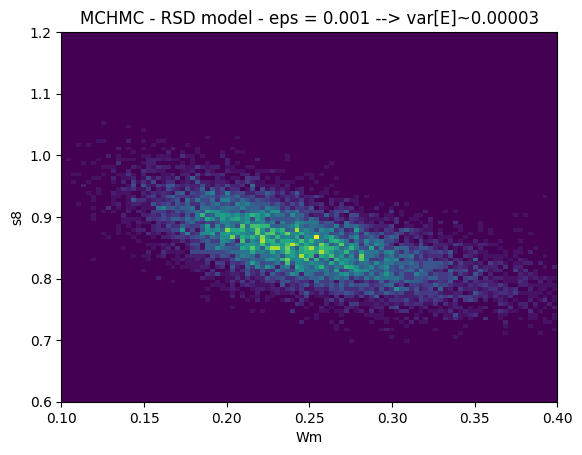

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [41]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [42]:
params, param_names, internal_names = sample(
    stat_model, mchmc, 10000;
    monitor_energy=true, 
    dialog=true)

hello
world


[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 25.351749410455724
eps: 0.125 --> VarE: 33.48164702637927
eps: 0.0625 --> VarE: 6.6514272447338465
eps: 0.03125 --> VarE: 1.9651971293291368


[ Info: Found eps ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


out there


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :state, :start_time, :stop_time), Tuple{TuringTarget, Sampler, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Float64}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


In [43]:
internal_names

2-element Vector{Symbol}:
 :E
 :logp

## NUTS

In [17]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.00078125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 13.4 seconds
Compute duration  = 13.4 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm   -0.9904    0.0100     0.0001    0.0008   44.3147    1.0057      ⋯
          σ8    0.0011    0.0007     0.0000    0.0001   43.5766    1.0060      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [18]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 -0.985152  0.000763544  -70.5609   1.0  …  1.0  0.0  0.0139822  0.0139822
 -0.985152  0.000763544  -70.5609   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985237  0.000759478  -70.3053   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985237  0.000759478  -70.3053   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985348  0.000742     -70.0672   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985348  0.000742     -70.0672   5.0  …  2.0  0.0  0.0139822  0.0139822
 -0.985348  0.000742     -70.0672   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985348  0.000742     -70.0672   3.0     1.0  0.0  0.0139822  0.0139822
 -0.985348  0.000742     -70.0672   9.0

In [19]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

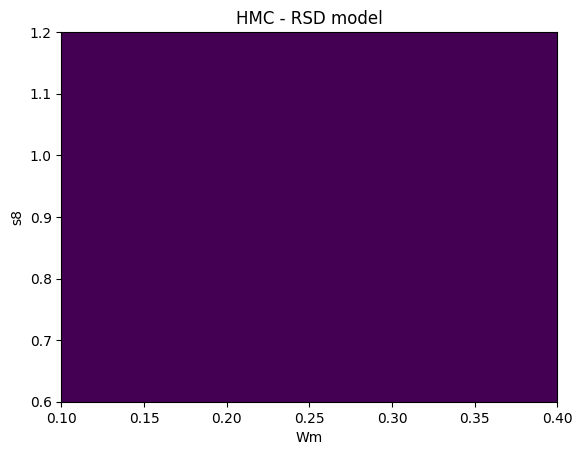

In [20]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");